#**House Prices - Advanced Regression Techniques**


# Problem Definition
Predict the sales price for each house. For each Id in the test set, predict the value of the SalePrice variable. 

# Import the libraries

In [ ]:
# Python
import math, time, random, datetime
from IPython.display import HTML
from functools import reduce

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inlinea
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('white')
import missingno as msno
colormap = plt.cm.RdBu
colors = ['tomato','teal','darkred','darkolivegreen','darkorange','darkslategray', 'darkgoldenrod','maroon','seagreen','cadetblue']
from scipy.stats import norm
from scipy import stats

# Data Prep
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer

# Model Training
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance


#Model Evaluation
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV , KFold , StratifiedKFold

# Warning Control
import warnings
warnings.filterwarnings('ignore')

# Part 1: Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "drive/My Drive/Colab Notebooks/data/kaggle/house-sales"

In [ ]:
path = "drive/My Drive/Colab Notebooks/data/kaggle/house-sales/"
train = pd.read_csv(path+"train.csv", index_col='Id')
test = pd.read_csv(path+"test.csv", index_col='Id')

# Part 2: Exploratory Data Analysis 


Exploratory data analysis method is either non-graphical or graphical. Each method is either univariate or multivariate.

### Dimensions of Dataset

In [ ]:
train.shape

(1460, 80)

In [ ]:
test.shape

(1459, 79)

79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa

###Target Distribution

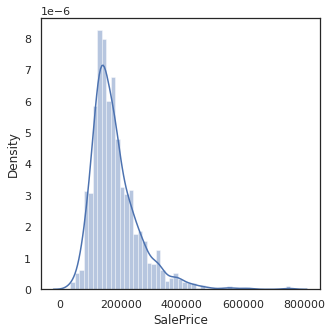

In [ ]:
plt.figure(figsize=(5, 5))
sns.distplot(train['SalePrice'])

'SalePrice' is not normal as it shows positive skewness and does not follow the diagonal line. Log transformations works well in case of positive skewness.

### Univariate non-graphical EDA

The usual goal of univariate non-graphical EDA is to better understand the “sample distribution”  and also to make some preliminary conclusions.

#### Statistical Summary

In [ ]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Qualitative vs Quantitative Data Types

### Types of Data Variables

In [ ]:
dfnum = train.select_dtypes('number')
dfcat=  train.select_dtypes('object')
dftime = train.select_dtypes(include=['datetime64','timedelta64'])

### Numerical or Quantitative Data Variables
- Histogram, Pairplots, Correlation


###Univariate Plots
Used to better understand each attribute

#### Density Plots
Density plots are another way of getting a quick idea of the distribution of each attribute.  We can see the distribution for each attribute is clearer than the histograms.

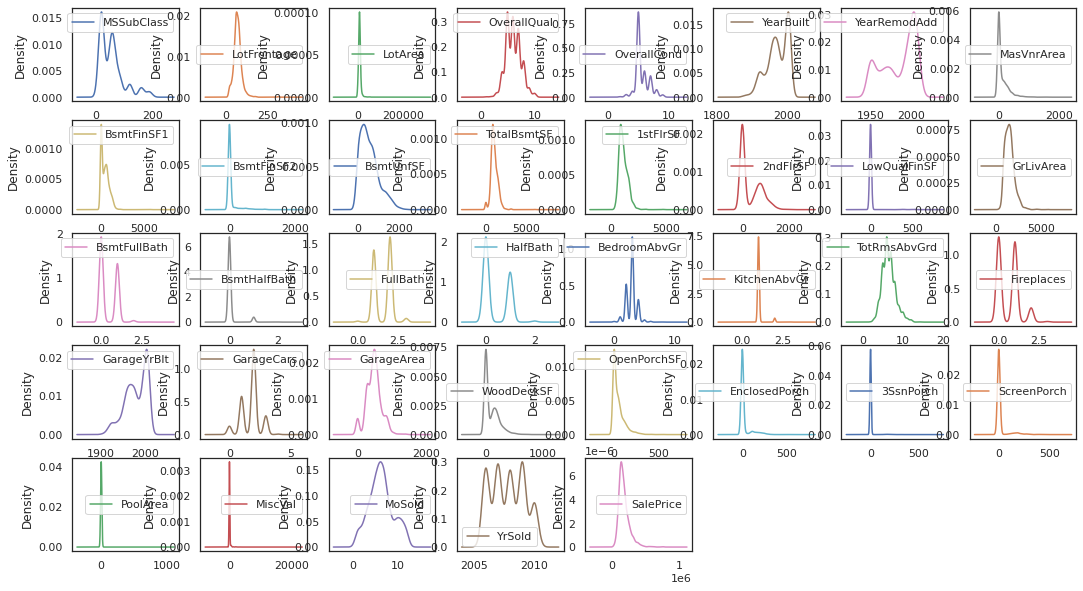

In [ ]:
train.plot(kind='density', subplots=True, layout=(5,8), sharex=False,figsize=(18,10))
plt.show()

###Multivariate Plots
Used to better understand the relationships between attributes.

#### Correlation
Correlation gives an indication of how related the changes are between two variables. If two
variables change in the same direction they are positively correlated.

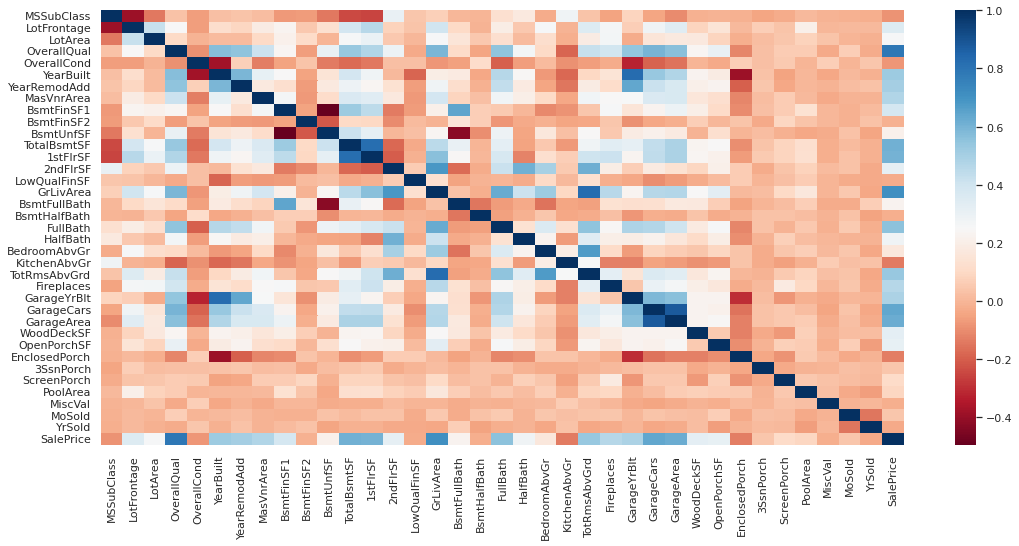

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(train.corr(), annot=False, cmap=colormap)

In [ ]:
cor = train.corr()
cor_target = abs(cor["SalePrice"])
#Selecting highly correlated features
highly_corr = cor_target[cor_target>0.5]
highly_corr = highly_corr.index.tolist()

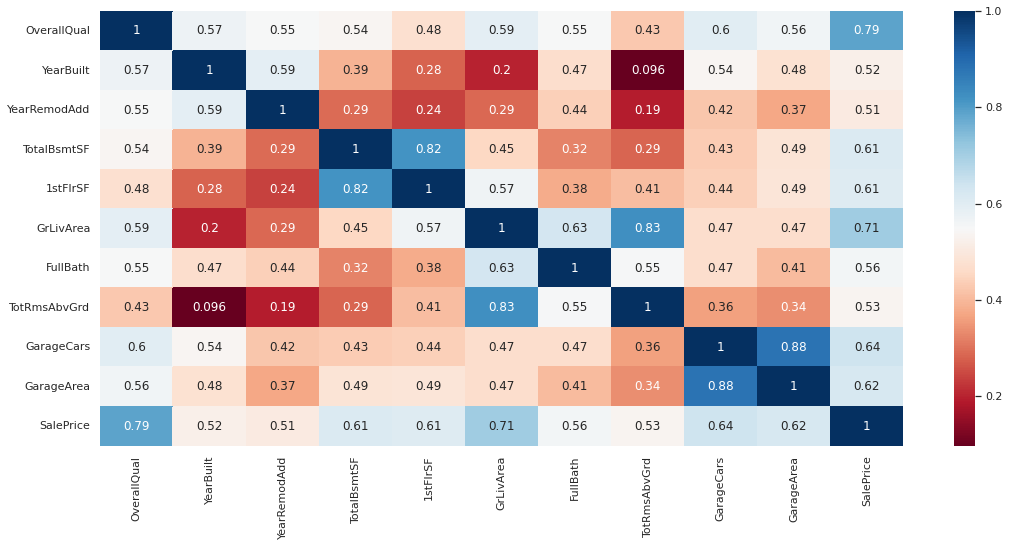

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(train[highly_corr].corr(), annot=True, cmap=colormap)

#Part 3: Data Preparation

Data preparation is that step in which the data gets transformed so that machine learning algorithms can easily parse it.

#### Outliers
Boxplots summarize the distribution of each attribute, drawing a line for the median, the 25th and 75th percentiles. The whiskers give an idea of the spread of the data and dots outside of the whiskers
show **outlier values**.

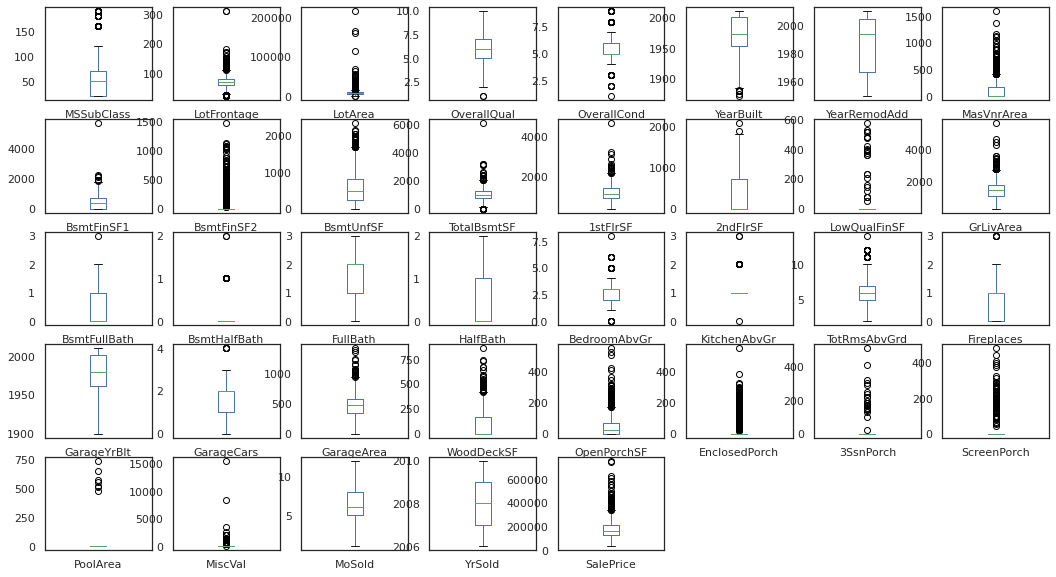

In [ ]:
train.plot(kind='box', subplots=True, layout=(5,8), sharex=False,figsize=(18,10))
plt.show()

In [ ]:
def remove_outliers(df, lower, upper):
  lower_range = df.quantile(lower)
  upper_range = df.quantile(upper)
  IQR = upper_range - lower_range
  df = df[~((df < (lower_range - 1.5 * IQR)) |(df > (upper_range + 1.5 * IQR))).any(axis=1)]
  return df

In [ ]:
train.shape

(1460, 80)

In [ ]:
train = remove_outliers(train, .05, .95)

In [ ]:
train.shape

(1266, 80)

##Data Quality Assessment

###Duplicate Values

Check if there are duplicated rows.

In [ ]:
duplicate_rows_df = train[train.duplicated()]
duplicate_rows_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


There aren't any duplicated rows.

###Feature Value Range
Check min-max ranges for possible unusual values (such as negative values for Age or Fare etc...)

In [ ]:
for col in dfnum.columns:
  print(col, "Minimum", dfnum[col].min())

MSSubClass Minimum 20
LotFrontage Minimum 21.0
LotArea Minimum 1300
OverallQual Minimum 1
OverallCond Minimum 1
YearBuilt Minimum 1872
YearRemodAdd Minimum 1950
MasVnrArea Minimum 0.0
BsmtFinSF1 Minimum 0
BsmtFinSF2 Minimum 0
BsmtUnfSF Minimum 0
TotalBsmtSF Minimum 0
1stFlrSF Minimum 334
2ndFlrSF Minimum 0
LowQualFinSF Minimum 0
GrLivArea Minimum 334
BsmtFullBath Minimum 0
BsmtHalfBath Minimum 0
FullBath Minimum 0
HalfBath Minimum 0
BedroomAbvGr Minimum 0
KitchenAbvGr Minimum 0
TotRmsAbvGrd Minimum 2
Fireplaces Minimum 0
GarageYrBlt Minimum 1900.0
GarageCars Minimum 0
GarageArea Minimum 0
WoodDeckSF Minimum 0
OpenPorchSF Minimum 0
EnclosedPorch Minimum 0
3SsnPorch Minimum 0
ScreenPorch Minimum 0
PoolArea Minimum 0
MiscVal Minimum 0
MoSold Minimum 1
YrSold Minimum 2006
SalePrice Minimum 34900


In [ ]:
for col in dfnum.columns:
  print(col, "Maximum:", dfnum[col].max())

MSSubClass Maximum: 190
LotFrontage Maximum: 313.0
LotArea Maximum: 215245
OverallQual Maximum: 10
OverallCond Maximum: 9
YearBuilt Maximum: 2010
YearRemodAdd Maximum: 2010
MasVnrArea Maximum: 1600.0
BsmtFinSF1 Maximum: 5644
BsmtFinSF2 Maximum: 1474
BsmtUnfSF Maximum: 2336
TotalBsmtSF Maximum: 6110
1stFlrSF Maximum: 4692
2ndFlrSF Maximum: 2065
LowQualFinSF Maximum: 572
GrLivArea Maximum: 5642
BsmtFullBath Maximum: 3
BsmtHalfBath Maximum: 2
FullBath Maximum: 3
HalfBath Maximum: 2
BedroomAbvGr Maximum: 8
KitchenAbvGr Maximum: 3
TotRmsAbvGrd Maximum: 14
Fireplaces Maximum: 3
GarageYrBlt Maximum: 2010.0
GarageCars Maximum: 4
GarageArea Maximum: 1418
WoodDeckSF Maximum: 857
OpenPorchSF Maximum: 547
EnclosedPorch Maximum: 552
3SsnPorch Maximum: 508
ScreenPorch Maximum: 480
PoolArea Maximum: 738
MiscVal Maximum: 15500
MoSold Maximum: 12
YrSold Maximum: 2010
SalePrice Maximum: 755000


##Data Cleaning

###Missing Data

In [ ]:
train.shape

(1266, 80)

In [ ]:
test.shape

(1459, 79)

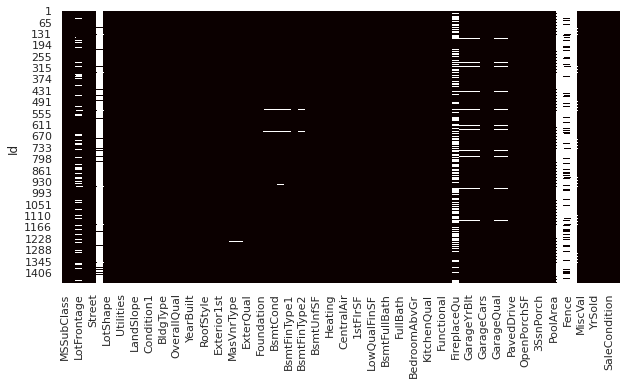

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(train.isnull(), cbar=False, cmap = "hot")

In [ ]:
def check_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent missing'])
    df = df.loc[df['Percent missing'] > 0]
    return df

In [ ]:
train_missing = check_missing(train) 
train_missing_cols = train_missing.index.tolist()  
train_missing.shape

(19, 2)

In [ ]:
test_missing = check_missing(test) 
test_missing_cols = test_missing.index.tolist()
test_missing.shape

(33, 2)

####Drop Columns

In [ ]:
train.shape

(1266, 80)

In [ ]:
test.shape

(1459, 79)

In [ ]:
train_missing_80 = train_missing.loc[train_missing['Percent missing'] > 80]
test_missing_80 = test_missing.loc[test_missing['Percent missing'] > 80]

In [ ]:
#make sure the the same number of columns are removed from both train and test data
if train_missing_80.index.tolist() == test_missing_80.index.tolist():
  train.drop(train_missing_80.index.tolist(), axis = 1, inplace = True)
  test.drop(test_missing_80.index.tolist(), axis = 1, inplace = True)

In [ ]:
train_missing = check_missing(train) 
train_missing_cols = train_missing.index.tolist()  
train_missing.shape

(15, 2)

In [ ]:
test_missing = check_missing(test) 
test_missing_cols = test_missing.index.tolist()
test_missing.shape

(29, 2)

###Imputation
Imputation refers to a technique used to replace missing values. 

<u>**Imputation should be done over the training set, and then propagated to the test set.**</u> This means that the mean/median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting due to **data leakage**. <u>**Data leakage**</u> is when information from outside the training dataset is used to create the model. Data leakage will create a very optimistic and/or invalid predictive model.

In [ ]:
train.shape

(1266, 76)

In [ ]:
test.shape

(1459, 75)

In [ ]:
# initialize imputer 
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
def impute_missing_data (df, num_imputer, cat_imputer):
  #get missing cols
  missing = check_missing(df) 
  missing = missing.loc[missing['Percent missing'] > 0]
  missing_cols = missing.index.tolist()

  #find columns with missing data
  num_cols_with_na = df[missing_cols].select_dtypes('number').columns.tolist()
  cat_cols_with_na = df[missing_cols].select_dtypes('object').columns.tolist()
  df_cols_with_na = num_cols_with_na + cat_cols_with_na

  #fit imputer to learn on missing data cols and add to dataframe
  imputed_num_data = num_imputer.fit(df[num_cols_with_na]).transform(df[num_cols_with_na])
  imputed_cat_data = cat_imputer.fit(df[cat_cols_with_na]).transform(df[cat_cols_with_na])
  
  #create imputed dfs
  imputed_num_df = pd.DataFrame(imputed_num_data, columns=num_cols_with_na)
  imputed_cat_df = pd.DataFrame(imputed_cat_data, columns=cat_cols_with_na)

  #return combined dfs
  imputed_df = pd.concat([imputed_num_df, imputed_cat_df], axis=1)
  return df_cols_with_na, imputed_df


Train Data

In [ ]:
train_imputed_data = impute_missing_data (train, num_imputer, cat_imputer)

In [ ]:
train_missing_cols = train_imputed_data[0]
train_imputed_df = train_imputed_data[1]

In [ ]:
train[train_missing_cols] = train_imputed_df.values

In [ ]:
check_missing(train)

,Total,Percent missing


In [ ]:
train.shape

(1266, 76)

Test Data

In [ ]:
test_imputed_data = impute_missing_data (test, num_imputer, cat_imputer)

In [ ]:
test_missing_cols = test_imputed_data[0]
test_imputed_df = test_imputed_data[1]

In [ ]:
test[test_missing_cols] = test_imputed_df.values

In [ ]:
check_missing(test)

,Total,Percent missing


In [ ]:
test.shape

(1459, 75)

##Data Transformation

It is a good idea merge train and test data while performing feature engineering and encoding categorical variables. For instance, when encoding or binning, combining both the train and test data will guarantee all categories are encoded.

###Combine Train and Test Data
During data transformation, the train and test sets are usually combined to maintain consistency between them.

In [ ]:
# Seperate features and target variable
X_train = train.drop(['SalePrice'], axis=1)
y_train = train.SalePrice

In [ ]:
# Concatenate train and test data
house_data = pd.concat([X_train, test], axis=0)

### Feature Engineering

####Derived Variables

Derived Variables are generated by applying domain knowledge to come up with more meaningful features by extracting and utilizing parts of a column into new features.

In [ ]:
# house_data["OverallGrade"] = house_data["OverallQual"] * house_data["OverallCond"]
# house_data["AllKitchenScore"] = house_data["KitchenAbvGr"] * house_data["KitchenQual"]
# house_data["AllFireplaceScore"] = house_data["Fireplaces"] * house_data["FireplaceQu"]
# house_data["AllBath"] = house_data["BsmtFullBath"] + (0.5 * house_data["BsmtHalfBath"]) + house_data["FullBath"] + (0.5 * house_data["HalfBath"])
# house_data["AllSF"] = house_data["GrLivArea"] + house_data["TotalBsmtSF"]
# house_data["AllFlrsSF"] = house_data["1stFlrSF"] + house_data["2ndFlrSF"]
# house_data["AllPorchSF"] = house_data["OpenPorchSF"] + house_data["EnclosedPorch"] + house_data["3SsnPorch"] + house_data["ScreenPorch"]

In [ ]:
house_data['houseAge'] = house_data.YrSold - house_data.YearBuilt
house_data['reModeled'] = np.where(house_data.YearRemodAdd == house_data.YearBuilt, 0, 1)
house_data['isNew'] = np.where(house_data.YrSold == house_data.YearBuilt, 1, 0)

### Feature Scaling

#### Robust Scaler

RobustScaler transforms the feature vector by subtracting the median and then dividing by the interquartile range (75% value — 25% value).

Robust Scaler features using statistics that are robust to outliers. It is used to scale the feature to median and quantiles.

- “Rescaling” a vector means to add or subtract a constant and then multiply or divide by a constant, as you would do to change the units of measurement of the data, for example, to convert a temperature from Celsius to Fahrenheit.
- Scaling using median and quantiles consists of subtracting the median to all the observations, and then dividing by the interquantile difference.  
The interquantile difference is the difference between the 75th and 25th quantile:

$$IQR = 75^{th}quantile - 25^{th} quantile$$
$$\displaystyle X_{scaled} = \frac{(X - X_{median})} {IQR}$$

In [ ]:
rs = RobustScaler()

In [ ]:
numerical_cols = house_data.select_dtypes('number').columns.tolist()

In [ ]:
house_data[numerical_cols] = rs.fit_transform(house_data[numerical_cols])

### Encoding

Encoding is a crucial part of feature engineering. Encoding categorical features depends on amount of categories and features in data set, variable type and chosen model. 

 Label Encoding Non-Numerical Features: They are converted to numerical type with LabelEncoder. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [ ]:
ordinal_categoricals = [ "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
    "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope",
    "LotShape", "PavedDrive", "Street", "Utilities"]

####Label Encoding



Label Encoding is a popular encoding technique for non-numerical. In this technique, each label is assigned a unique integer. Mostly used for tree based models. 


In [ ]:
le=LabelEncoder()

In [ ]:
for col in ordinal_categoricals:
    house_data[col] = le.fit_transform(house_data[col])

#### One Hot Encoding

There are two options for one hot encoding. One can use OneHotEncoder or pd.get_dummies

In [ ]:
house_data_cat_cols = house_data.select_dtypes('object').columns.tolist()

In [ ]:
house_data = pd.get_dummies(house_data)

#Part 4: Model Training

###Split Train and Test Data

The test and train needs to be split prior to model training

In [ ]:
testlen = len(test)
X_train = house_data.iloc[:-testlen, :]
X_test = house_data.iloc[-testlen:, :]
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (1266, 212)
X_test.shape: (1459, 212)


### Regression Model Assumptions

Transformation is required to treat the skewed features and make them normally distributed.

In [ ]:
def normality_plot(X):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()


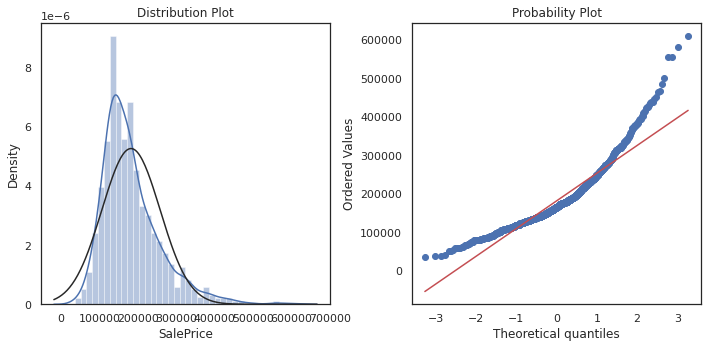

In [ ]:
normality_plot(y_train)

The data does not follow normal distribution in some cases. Data transformation(log(y) or 1/y, or other) will help.

In [ ]:
y_train = np.log1p(y_train)

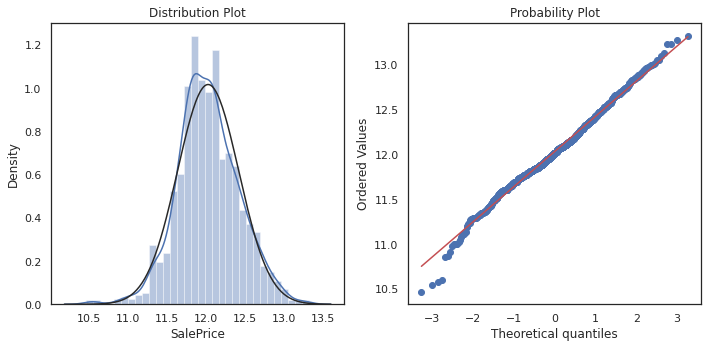

In [ ]:
normality_plot(y_train)

##Machine Learning Algorithms

In [ ]:
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'RidgeCV', 'RandomForestRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'XGBRegressor', ]  

In [ ]:
regressions = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha =0.0005, random_state=0),
    RidgeCV(),
    RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=0),
    BaggingRegressor(n_estimators=100),
    GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0),
    AdaBoostRegressor(n_estimators=100, random_state=0), 
    XGBRegressor(learning_rate=0.01,n_estimators=3460,
                 max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006),]

Every model in Scikit-learn has a score method after being trained on X_train, y_train. Models have a score method providing a default evaluation criterion for the problem they are designed to solve. 

In [ ]:
def predict_models(names, models, X_train, y_train):

    y_preds = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train).tolist()
        y_preds.append(y_pred)
 
    pred_dict = dict(zip(names, y_preds))
    pred_dict = pd.DataFrame.from_dict(pred_dict)
    pred_dict['Voting'] = pred_dict[pred_dict.columns.tolist()].mean(axis=1)
    return pred_dict

In [ ]:
pred_dict = predict_models(model_names, regressions, X_train, y_train)

[06:31:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pred_dict.head()

,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor,Voting
0,12.240948,12.241872,12.031867,12.242496,12.238189,12.234887,12.250257,12.236606,12.220955,12.215342
1,12.185604,12.179478,12.031867,12.165800,12.068439,12.085251,12.110102,11.840818,12.108110,12.086163
2,12.242123,12.244252,12.031867,12.247765,12.286409,12.283720,12.299763,12.235054,12.254291,12.236138
3,11.987484,11.991826,12.031867,11.994318,11.979367,11.960228,11.860265,12.040516,11.907953,11.972647
4,12.560947,12.563452,12.031867,12.571184,12.482778,12.495049,12.444926,12.642892,12.523276,12.479597


# Part 5: Model Evaluation Metrics 


##Evaluation

Root Mean Squared Error

RMSE is the square root of MSE which measures accuracy, to compare errors of different calculation models for the same dataset. It's also called the l-2 norm. Is the most popular norm, also known as the Euclidean norm. It is the shortest distance to go from one point to another.  
MSE takes the average of the square of the difference between the original values and the predicted values. Thus as a goal, we should try to minimize the cost function.

$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$$

$$ RMSE = \sqrt{\sum_{i=1}^{N}(y_i-y_{i}^{pred})^2} $$

The higher the n in an l-n norm, the more it disregards the values of the smaller components.  
L2 loss function most commonly used regression loss function. MSE is the sum of squared distances between our target variable and predicted values.

###Performance Metrics

In [ ]:
def get_metrics_values(y_test, pred_dict, metric_name):

  models = pred_dict.columns.tolist()

  metrics_list = []
  for model in models:
    if metric_name == 'RMSE':
      metric = mean_squared_error(y_test, pred_dict[model], squared=False)
    elif metric_name == 'RMSLE':
      metric = mean_squared_log_error(y_test, pred_dict[model], squared=False)
    metrics_list.append(metric)
  
  metrics_dict = dict(zip(models, metrics_list))
  metrics_df = pd.DataFrame([metrics_dict])
  metrics_df['Evaluation'] = metric_name
  first_col = metrics_df.pop('Evaluation')
  metrics_df.insert(0, 'Evaluation', first_col)
  return metrics_df

#### RMSE (sklearn)

In [ ]:
rmse = get_metrics_values(y_train, pred_dict, metric_name = 'RMSE')
rmse

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor,Voting
0,RMSE,0.090998,0.091784,0.097512,0.095582,0.085049,0.049133,0.048501,0.141355,0.046251,0.072435


#### RMSLE (sklearn)

In [ ]:
rmsle = get_metrics_values(y_train, pred_dict, metric_name = 'RMSLE')
rmsle

,Evaluation,LinearRegression,Ridge,Lasso,RidgeCV,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor,Voting
0,RMSLE,0.007092,0.007158,0.007606,0.007466,0.006664,0.003843,0.003875,0.010899,0.003579,0.005658


###Regression Metrics Analysis

In [ ]:
evaluation_rmse = pd.concat([rmse]).T
evaluation_rmsle = pd.concat([rmsle]).T

In [ ]:
def get_evaluation_df(evaluation_df, metric_name):
  evaluation_df.columns = evaluation_df.iloc[0].values.tolist()
  evaluation_df['Model'] = evaluation_df.index
  first_col = evaluation_df.pop('Model')
  evaluation_df.insert(0, 'Model', first_col)
  evaluation_df.reset_index(inplace=True)
  evaluation_df.drop(evaluation_df.index[evaluation_df['Model'] == 'Evaluation'], inplace=True)
  evaluation_df.drop('index', axis=1, inplace=True)
  evaluation_df.sort_values(by=[metric_name], ascending=True, inplace=True)
  return evaluation_df

In [ ]:
evaluation_rmse = get_evaluation_df(evaluation_rmse, metric_name = 'RMSE')
evaluation_rmsle = get_evaluation_df(evaluation_rmsle, metric_name = 'RMSLE')

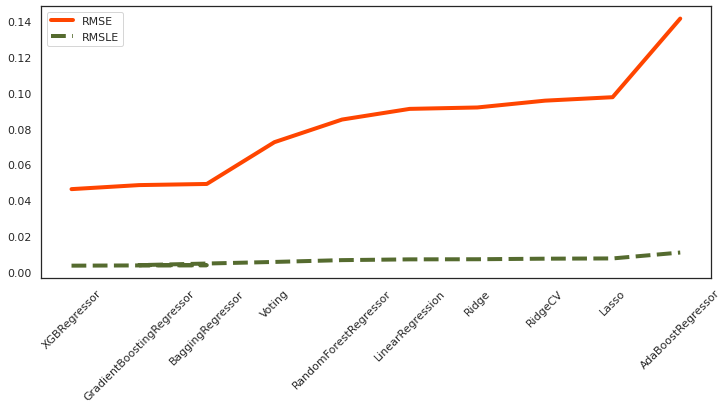

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(evaluation_rmse.Model,evaluation_rmse.RMSE, color='orangered', linewidth=4, label="RMSE")
plt.plot(evaluation_rmsle.Model, evaluation_rmsle.RMSLE, color='darkolivegreen', linewidth=4, label="RMSLE", linestyle='dashed')
plt.xticks(rotation = 45) # Rotates X-Axis 
plt.legend()
plt.show()

###Best Model


In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =0)

In [ ]:
gbr = gbr.fit(X_train, y_train)

In [ ]:
xgb = XGBRegressor(learning_rate=0.01,n_estimators=3460, max_depth=3, min_child_weight=0, gamma=0, subsample=0.7, colsample_bytree=0.7, objective='reg:linear', nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006)

In [ ]:
xgb = xgb.fit(X_train, y_train)

[07:17:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
br = BaggingRegressor(n_estimators = 200, n_jobs = -1, random_state = 10)

In [ ]:
br = br.fit(X_train, y_train)

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_split=3, random_state=3)

In [ ]:
rfr = rfr.fit(X_train, y_train)

In [ ]:
def ensemble_models(X):
    return ((0.1 * rfr.predict(X)) + 
           (0.2 * br.predict(X)) +
           (0.3 * gbr.predict(X)) +            
           (0.4 * xgb.predict(X)))

In [ ]:
y_pred_rfr = rfr.predict(X_train)
y_pred_br = br.predict(X_train)
y_pred_xgb = xgb.predict(X_train)
y_pred_gbr = gbr.predict(X_train)
y_pred_ensemble = ensemble_models(X_train)

In [ ]:
mean_squared_error(y_train, y_pred_rfr, squared=False)

0.11892016711593555

In [ ]:
mean_squared_error(y_train, y_pred_br, squared=False)

0.04906900682248679

In [ ]:
mean_squared_error(y_train, y_pred_gbr, squared=False)

0.048501142370762286

In [ ]:
mean_squared_error(y_train, y_pred_xgb, squared=False)

0.04625052246358933

In [ ]:
mean_squared_error(y_train, y_pred_ensemble, squared=False)

0.04723700155196853

##Feature Selection

In [ ]:
best_predictor = xgb

In [ ]:
important_feats = best_predictor.feature_importances_

In [ ]:
def feature_importances (model, X, y, percentage):
  model.fit(X,y)
  sorted_idx = model.feature_importances_.argsort()
  feat_importances = pd.Series(model.feature_importances_[sorted_idx], index=X.columns[sorted_idx])
  feat_importances = feat_importances.to_frame(name='FeatureRating')
  return feat_importances.sort_values('FeatureRating',ascending=False).head(round(percentage*len(feat_importances)))

In [ ]:
selected_features = feature_importances(best_predictor, X_train, y_train, 0.15)

[05:31:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


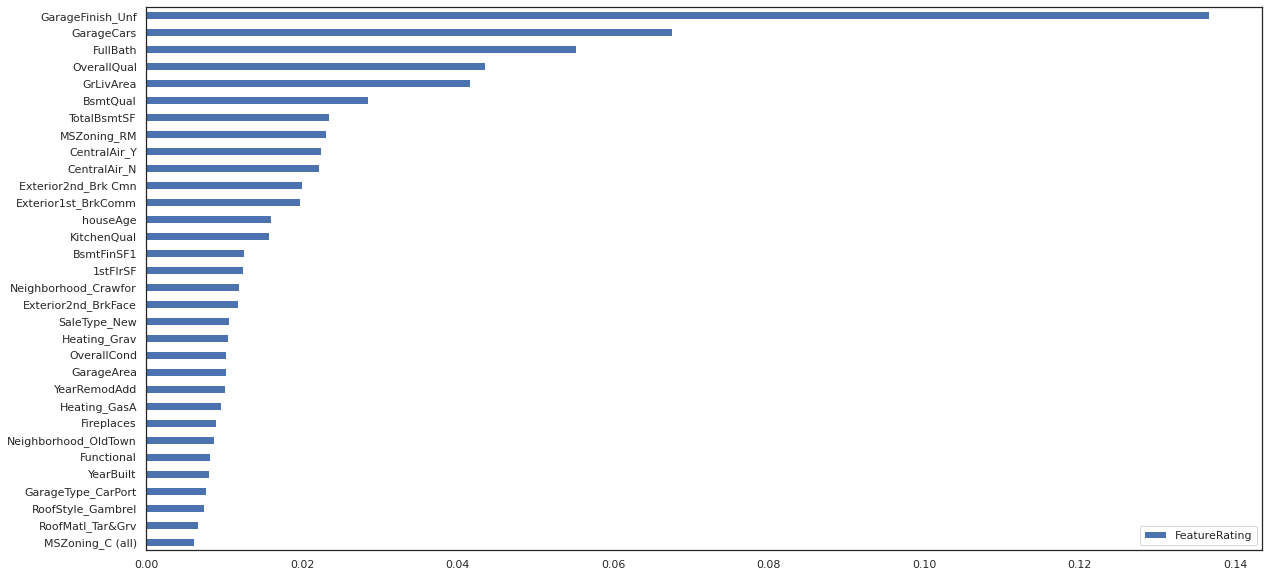

In [ ]:
selected_features.sort_values('FeatureRating',ascending=True).plot(kind='barh', figsize = (20,10))

In [ ]:
selected_cols = selected_features.index.tolist()
best_predictor.fit(X_train[selected_cols], y_train).predict(X_train[selected_cols]) 

[05:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([12.23644 , 12.07491 , 12.280585, ..., 12.075833, 12.227796,
       11.885573], dtype=float32)

# Part 6: Model Deployment

###Submission
In this case, deployment involves submitting data to Kaggle.

In [ ]:
predictions = best_predictor.predict(X_test)

In [ ]:
#for selected columns
# selected_predictions = best_predictor.predict(X_test[selected_cols])

In [ ]:
predictions

array([11.776839, 12.013793, 12.147041, ..., 11.962901, 11.637912,
       12.33759 ], dtype=float32)

In [ ]:
#inverse of numpy's log1p()
final_predictions  = np.e**predictions

In [ ]:
final_predictions

array([128837.98261603, 157837.10642828, 188516.55542012, ...,
       153197.98563547, 113554.45447854, 227440.57694501])

In [ ]:
#create submission dataframe and get add the datetime column
submission = pd.DataFrame()
submission['Id'] = X_test.index

In [ ]:
submission['SalePrice'] = final_predictions

In [ ]:
submission

,Id,SalePrice
0,1461,128837.982616
1,1462,157837.106428
2,1463,188516.555420
3,1464,191621.532214
4,1465,197315.466979
...,...,...
1454,2915,80837.464283
1455,2916,83280.711004
1456,2917,153197.985635
1457,2918,113554.454479


In [ ]:
#make sure the number of rows for submission and test data matches
print(len(submission))
print(len(X_test))

1459
1459


In [ ]:
# Convert submisison dataframe to csv and save on Google Drive
timestr = time.strftime("%Y%m%d-%H%M%S")
submission.to_csv(path + timestr +"home_price_submission.csv", index=False, encoding='utf-8-sig')
print('Submission CSV saved on Drive')

Submission CSV saved on Drive
